---
# 0. Imports

In [ ]:
# plotting libraries
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

from utils.utils import *

---
# 1. Exploratory Data Analysis (EDA)

## STEP 1 - Dataset import

In [39]:
### Load file --------------------------------------------
df = pd.read_csv('./../data/all-data.csv', sep = ",",encoding='ISO-8859-1')
df.head()

,Y,Notices
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## STEP 2 - Data Cleaning

In [40]:
# Eliminar duplicados y filas con valores nulos
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("Forma del dataset después de limpiar duplicados y valores nulos:", df.shape)

Forma del dataset después de limpiar duplicados y valores nulos: (4840, 2)


## STEP 3 - Sentiment class distribution

Distribución de clases de sentimiento:
Y
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17140\1147183563.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


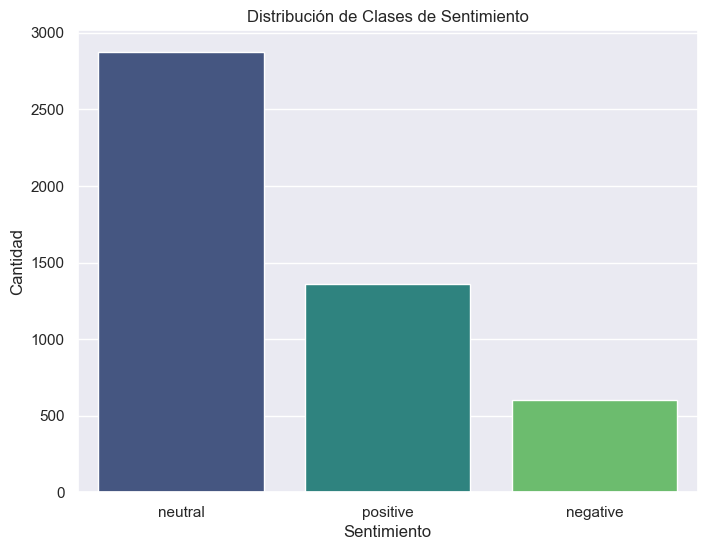

In [ ]:
# Contar las ocurrencias de cada clase en la columna "Y"
sentiment_counts = df['Y'].value_counts()
print("Distribución de clases de sentimiento:")
print(sentiment_counts)

# Visualizar la distribución con un gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Distribución de Clases de Sentimiento")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad")
plt.show()

## STEP 4 - Analysis word most frequent from category

In [42]:
sentiment_categories = df['Y'].unique()

# Iterar por cada categoría de sentimiento
for sentiment in sentiment_categories:
    # Filtrar las filas que correspondan a la categoría actual
    subset = df[df['Y'] == sentiment]
    # Concatenar todos los textos
    all_text = " ".join(subset['Notices'].tolist())
    # Preprocesar el texto
    tokens = preprocess_text(all_text)
    # Contar la frecuencia de cada palabra
    counter = Counter(tokens)
    most_common = counter.most_common(10)
    print(f"\nPalabras más frecuentes para el sentimiento '{sentiment}':")
    for word, count in most_common:
        print(f"{word}: {count}")


Palabras más frecuentes para el sentimiento 'neutral':
company: 506
eur: 315
said: 237
finland: 218
finnish: 215
million: 193
business: 190
group: 184
new: 179
sales: 163

Palabras más frecuentes para el sentimiento 'negative':
eur: 400
mn: 237
profit: 156
net: 104
company: 100
finnish: 99
sales: 98
operating: 97
period: 88
quarter: 79

Palabras más frecuentes para el sentimiento 'positive':
eur: 595
mn: 262
company: 240
said: 230
finnish: 198
net: 196
sales: 192
profit: 191
million: 170
year: 143


## STEP 5 - Word Cloud for each category

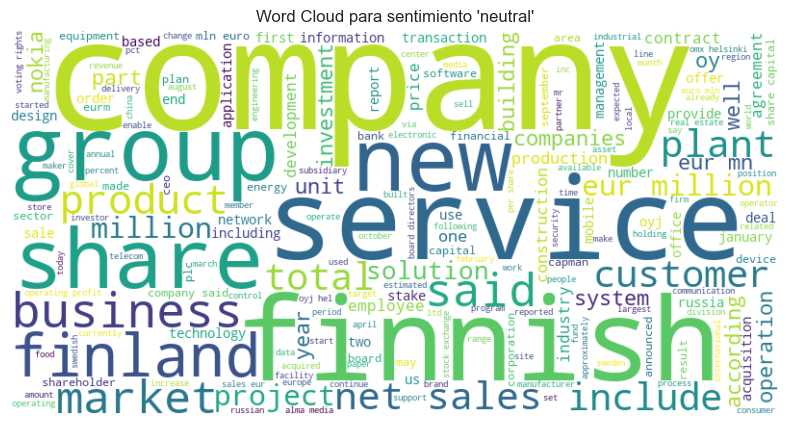

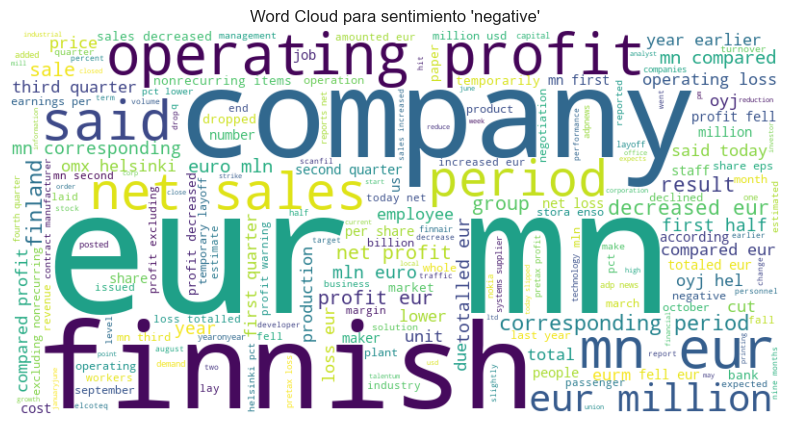

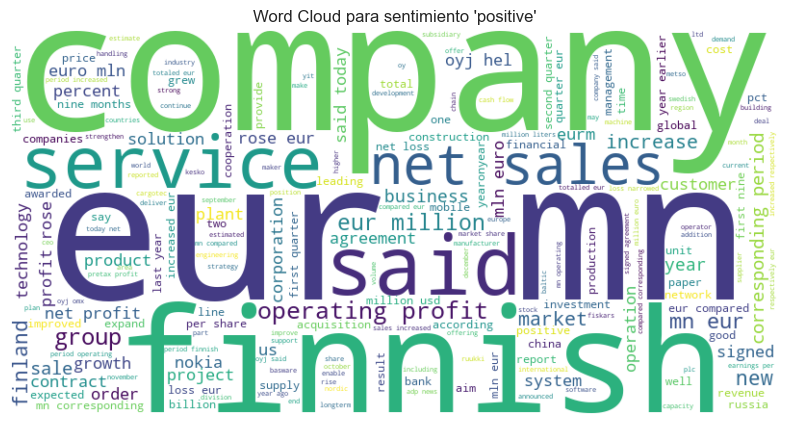

In [43]:
for sentiment in sentiment_categories:
    subset = df[df['Y'] == sentiment]
    all_text = " ".join(subset['Notices'].tolist())
    tokens = preprocess_text(all_text)
    # Reconstruir el texto a partir de tokens preprocesados
    text_processed = " ".join(tokens)
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_processed)
    
    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud para sentimiento '{sentiment}'")
    plt.show()

---
# 2: Simple Methods (Baseline Models)

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

## 2.1 Lexicon-Based Sentiment Analysis

In [44]:
# Cargar el diccionario Loughran-McDonald
lexicon = pd.read_csv("./../data/loughran_mcdonald_dictionary.csv")

# Crear conjuntos de palabras positivas y negativas (pasando todo a minúsculas)
positive_words = set(lexicon[lexicon['Positive'] > 0]['Word'].str.lower().tolist())
negative_words = set(lexicon[lexicon['Negative'] > 0]['Word'].str.lower().tolist())


def lexicon_sentiment(text):
    tokens = preprocess_text(text)
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    score = pos_count - neg_count
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Aplicar el análisis léxico a cada texto
df['predicted_sentiment_lexicon'] = df['Notices'].apply(lexicon_sentiment)

# Mostrar reporte de clasificación para el método léxico
print("Reporte de clasificación - Método Lexicon-Based:")
print(classification_report(df['Y'], df['predicted_sentiment_lexicon']))

Reporte de clasificación - Método Lexicon-Based:
              precision    recall  f1-score   support

    negative       0.46      0.43      0.44       604
     neutral       0.66      0.86      0.75      2873
    positive       0.62      0.24      0.35      1363

    accuracy                           0.63      4840
   macro avg       0.58      0.51      0.51      4840
weighted avg       0.63      0.63      0.60      4840



## 2.2 Bag-of-Words (BoW) + Clasificador

In [45]:
# Dividir el dataset en entrenamiento y prueba
X = df['Notices']
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir el texto a una matriz de frecuencias usando CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### 2.2.1 Clasificador Naïve Bayes

In [64]:
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=10, n_jobs=-1)
grid_nb.fit(X_train_bow, y_train)
y_pred_nb = grid_nb.predict(X_test_bow)

print("Desempeño del Clasificador Naïve Bayes:")
print("Mejores parámetros:", grid_nb.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Desempeño del Clasificador Naïve Bayes:
Mejores parámetros: {'alpha': 1.0}

Accuracy: 0.7107438016528925
              precision    recall  f1-score   support

    negative       0.62      0.42      0.51       118
     neutral       0.77      0.86      0.81       563
    positive       0.60      0.54      0.57       287

    accuracy                           0.71       968
   macro avg       0.66      0.61      0.63       968
weighted avg       0.70      0.71      0.70       968



### 2.2.2 Clasificador Logistic Regression

In [63]:
param_grid_lr = {'C': [0.1, 1, 10, 100], 'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=10, n_jobs=-1)
grid_lr.fit(X_train_bow, y_train)
y_pred_lr = grid_lr.predict(X_test_bow)


print("Desempeño del Clasificador Logistic Regression:")
print("Mejores parámetros:", grid_lr.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Desempeño del Clasificador Logistic Regression:
Mejores parámetros: {'C': 1, 'penalty': 'l2'}

Accuracy: 0.734504132231405
              precision    recall  f1-score   support

    negative       0.73      0.47      0.57       118
     neutral       0.75      0.90      0.82       563
    positive       0.69      0.53      0.60       287

    accuracy                           0.73       968
   macro avg       0.72      0.63      0.66       968
weighted avg       0.73      0.73      0.72       968



---
# 3: Intermediate Models (Machine Learning & Topic Modeling)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## 3.1 TF-IDF + Machine Learning Models

In [72]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Notices'])
y = df['Y']

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

### 3.1.1 SVM

In [73]:
param_grid_svm = {'C': [0.1, 1, 10, 100]}
grid_svm = GridSearchCV(LinearSVC(max_iter=10000, random_state=42), param_grid_svm, cv=10, n_jobs=-1)
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)


print("SVM:")
print("Mejores parámetros:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM:
Mejores parámetros: {'C': 1}
Accuracy: 0.743801652892562
              precision    recall  f1-score   support

    negative       0.71      0.50      0.59       121
     neutral       0.76      0.90      0.82       575
    positive       0.71      0.53      0.60       272

    accuracy                           0.74       968
   macro avg       0.73      0.64      0.67       968
weighted avg       0.74      0.74      0.73       968



### 3.1.2 Random Forest

In [74]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)


print("Random Forest:")
print("Mejores parámetros:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7520661157024794
              precision    recall  f1-score   support

    negative       0.82      0.41      0.55       121
     neutral       0.74      0.95      0.84       575
    positive       0.77      0.47      0.59       272

    accuracy                           0.75       968
   macro avg       0.78      0.61      0.66       968
weighted avg       0.76      0.75      0.73       968



### 3.1.3 XGBoost

In [75]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid_xgb, cv=10, n_jobs=-1)
grid_xgb.fit(X_train, y_train_enc)
y_pred_xgb = grid_xgb.predict(X_test)


print("XGBoost:")
print("Mejores parámetros:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.7407024793388429
              precision    recall  f1-score   support

    negative       0.71      0.50      0.59       121
     neutral       0.75      0.90      0.82       575
    positive       0.71      0.50      0.59       272

    accuracy                           0.74       968
   macro avg       0.72      0.64      0.67       968
weighted avg       0.74      0.74      0.73       968



## 3.2 Dimensionality Reduction with LSA (Latent Semantic Analysis)

In [76]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_lsa = svd.fit_transform(X_train)
X_test_lsa = svd.transform(X_test)
param_grid_lr_lsa = {'C': [0.1, 1, 10, 100]}
grid_lr_lsa = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr_lsa, cv=10, n_jobs=-1)
grid_lr_lsa.fit(X_train_lsa, y_train)
y_pred_lsa = grid_lr_lsa.predict(X_test_lsa)


print("Logistic Regression on LSA-transformed data:")
print("Mejores parámetros:", grid_lr_lsa.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lsa))
print(classification_report(y_test, y_pred_lsa))

Logistic Regression on LSA-transformed data:
Mejores parámetros: {'C': 10}
Accuracy: 0.6849173553719008
              precision    recall  f1-score   support

    negative       0.67      0.38      0.48       121
     neutral       0.70      0.91      0.79       575
    positive       0.61      0.35      0.44       272

    accuracy                           0.68       968
   macro avg       0.66      0.55      0.57       968
weighted avg       0.67      0.68      0.66       968



## 3.3 Topic Modeling with LDA (Latent Dirichlet Allocation)

In [77]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)
param_grid_lr_lda = {'C': [0.1, 1, 10, 100]}
grid_lr_lda = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr_lda, cv=10, n_jobs=-1)
grid_lr_lda.fit(X_train_lda, y_train)
y_pred_lda = grid_lr_lda.predict(X_test_lda)


print("Logistic Regression on LDA topics:")
print("Mejores parámetros:", grid_lr_lda.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression on LDA topics:
Mejores parámetros: {'C': 1}
Accuracy: 0.6033057851239669
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       121
     neutral       0.63      0.94      0.75       575
    positive       0.40      0.17      0.23       272

    accuracy                           0.60       968
   macro avg       0.34      0.37      0.33       968
weighted avg       0.49      0.60      0.51       968



c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\ML1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
